In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = "data/synpop_related"
seed_data = pd.read_csv(os.path.join(data_folder, 'pp_sample_ipu.csv'))
seed_data = seed_data.drop(columns=["serialno", "sample_geog"])
seed_data

,age,sex,relationship,persinc,nolicence,anywork
0,50-59,M,Main,$1000-1249 p.w.,Some Licence,Y
1,40-49,F,Spouse,$1-199 p.w.,Some Licence,N
2,10-19,F,Child,Zero Income,No Licence,N
3,0-9,F,Child,Zero Income,No Licence,N
4,50-59,F,Parent,$1-199 p.w.,Some Licence,N
...,...,...,...,...,...,...
75404,60-69,F,Main,$400-599 p.w.,Some Licence,Y
75405,70-79,M,Main,$300-399 p.w.,Some Licence,N
75406,70-79,F,Spouse,$300-399 p.w.,Some Licence,N
75407,70-79,F,Main,$400-599 p.w.,Some Licence,N


In [3]:
saa_data = pd.read_csv(os.path.join(data_folder, 'SAA_PP_seed_test.csv'))
csp_data = pd.read_csv(os.path.join(data_folder, 'csp_results_seed_all.csv'))
ipu_data = pd.read_csv(os.path.join(data_folder, 'syn_pp_ipu.csv'))

In [4]:
pp_persinc_order = [
    "Negative Income",
    "Zero Income",
    '$1-199 p.w.',
    '$200-299 p.w.',
    '$300-399 p.w.',
    '$400-599 p.w.',
    '$600-799 p.w.',
    '$800-999 p.w.',
    '$1000-1249 p.w.',
    '$1250-1499 p.w.',
    '$1500-1999 p.w.',
    '$2000+ p.w.'
]

In [5]:
check = {
    "IPU": ipu_data,
    # "SAA": saa_data,
    "CSP": csp_data,
    "VISTA": seed_data
}

In [ ]:
len(seed_data[seed_data["relationship"].isin(["Main", "Spouse", "Child"])]) / len(seed_data) * 100

90.63109177949582

In [6]:
def compare_rela(check_data, rela, attr):
    process_sub = {name: df[df["relationship"]==rela] for name, df in check_data.items()}
    if attr == "persinc":
        process_sub = {name: df[attr].value_counts(normalize=True).reindex(pp_persinc_order) for name, df in process_sub.items()}
    elif attr == "age":
        expected_order = list(sorted(seed_data[attr].unique()))
        expected_order.remove("100+")
        expected_order.append("100+")
        process_sub = {name: df[attr].value_counts(normalize=True).reindex(expected_order) for name, df in process_sub.items()}
    else:
        process_sub = {name: df[attr].value_counts(normalize=True).sort_index() for name, df in process_sub.items()}

    df_plot = pd.DataFrame(process_sub)
    df_plot.plot(kind="line", marker='o', figsize=(12, 6), title=f"Comparison of {rela} {attr} distribution")
    plt.xticks(ticks=range(len(df_plot.index)), labels=df_plot.index, rotation=45)

In [7]:
from scipy.spatial.distance import jensenshannon
import pandas as pd
import matplotlib.pyplot as plt

def compare_jsd_to_vista(check_data, relationships, attr):
    jsd_results = {}

    for rela in relationships:
        # Extract the subset for the given relationship from VISTA
        vista_df = check_data["VISTA"]
        vista_sub = vista_df[vista_df["relationship"] == rela]

        # Compute VISTA distribution
        if attr == "persinc":
            vista_dist = vista_sub[attr].value_counts(normalize=True).reindex(pp_persinc_order, fill_value=0)
        elif attr == "age":
            expected_order = list(sorted(seed_data[attr].unique()))
            expected_order.remove("100+")
            expected_order.append("100+")
            vista_dist = vista_sub[attr].value_counts(normalize=True).reindex(expected_order, fill_value=0)
        else:
            all_keys = sorted(set().union(*(df[df["relationship"] == rela][attr].unique() for df in check_data.values())))
            vista_dist = vista_sub[attr].value_counts(normalize=True).reindex(all_keys, fill_value=0)

        for name, df in check_data.items():
            if name == "VISTA":
                continue  # Skip VISTA itself
            df_sub = df[df["relationship"] == rela]
            if attr == "persinc":
                dist = df_sub[attr].value_counts(normalize=True).reindex(pp_persinc_order, fill_value=0)
            elif attr == "age":
                dist = df_sub[attr].value_counts(normalize=True).reindex(expected_order, fill_value=0)
            else:
                dist = df_sub[attr].value_counts(normalize=True).reindex(vista_dist.index, fill_value=0)

            jsd = jensenshannon(vista_dist, dist)
            jsd_results[(rela, name)] = jsd

    # Create DataFrame for plotting
    result_df = pd.Series(jsd_results).unstack().sort_index()
    result_df.plot(kind='bar', figsize=(10, 6), title=f"Jensen-Shannon Distance to VISTA for '{attr}' by Relationship")
    plt.ylabel("Jensen-Shannon Distance")
    plt.xlabel("Relationship")
    # plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    result_df.loc["mean"] = result_df.mean(axis=0)
    return result_df


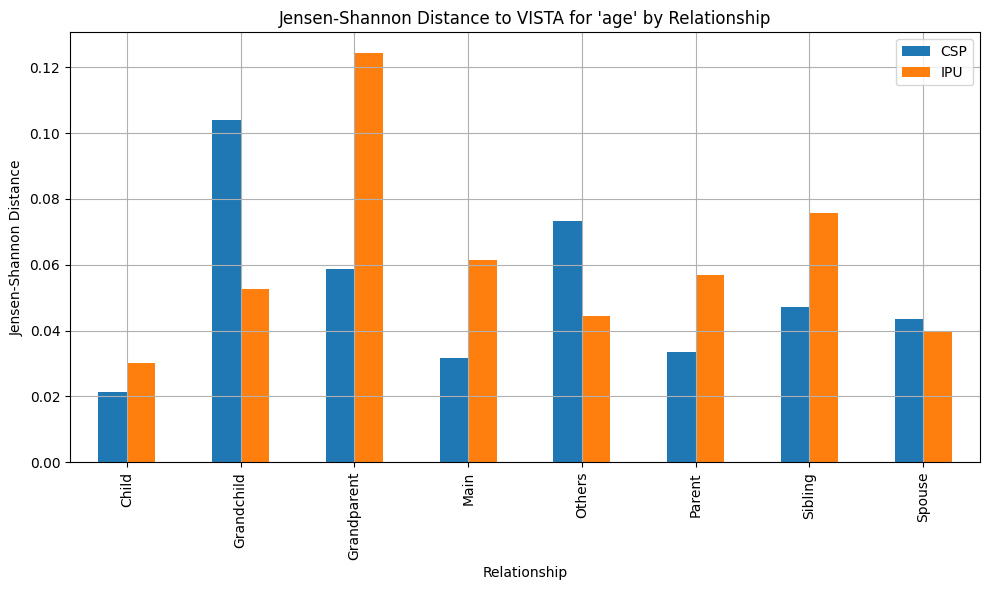

,CSP,IPU
Child,0.021338,0.030255
Grandchild,0.104090,0.052621
Grandparent,0.058695,0.124405
Main,0.031819,0.061502
Others,0.073282,0.044392
Parent,0.033527,0.056915
Sibling,0.047280,0.075620
Spouse,0.043581,0.039806
mean,0.051701,0.060690


In [8]:
compare_jsd_to_vista(check, list(seed_data["relationship"].unique()), "age")

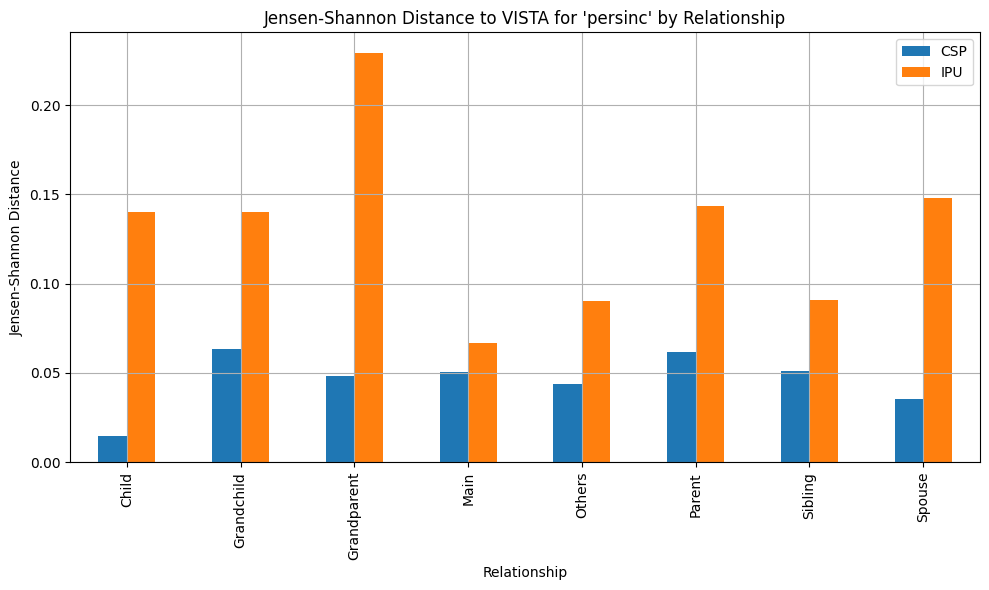

,CSP,IPU
Child,0.014661,0.140095
Grandchild,0.063210,0.140001
Grandparent,0.048176,0.229287
Main,0.050258,0.067032
Others,0.043543,0.090310
Parent,0.061798,0.143369
Sibling,0.050898,0.090709
Spouse,0.035580,0.147788
mean,0.046016,0.131074


In [9]:
compare_jsd_to_vista(check, list(seed_data["relationship"].unique()), "persinc")

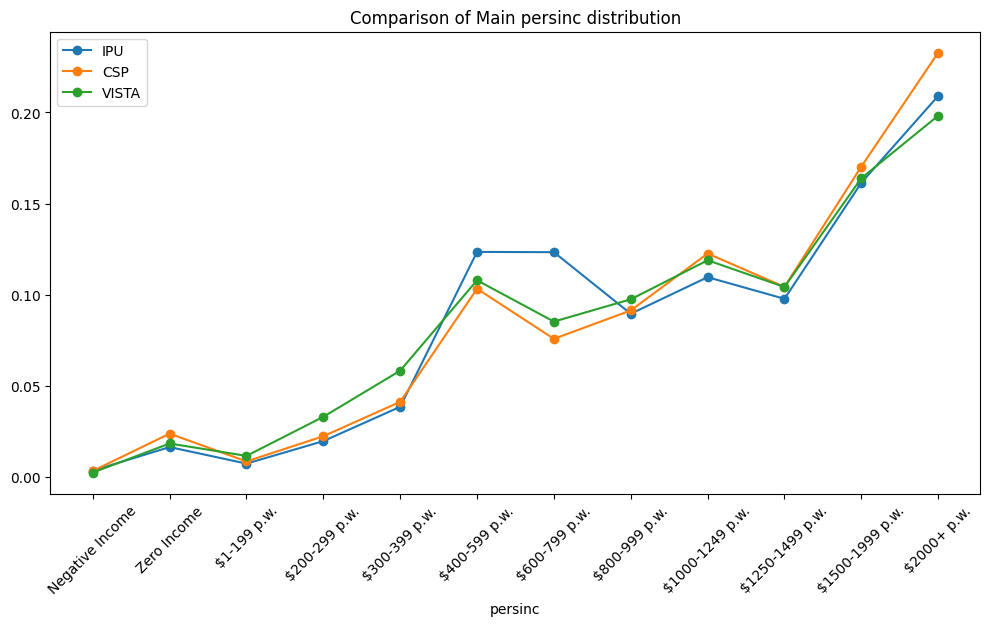

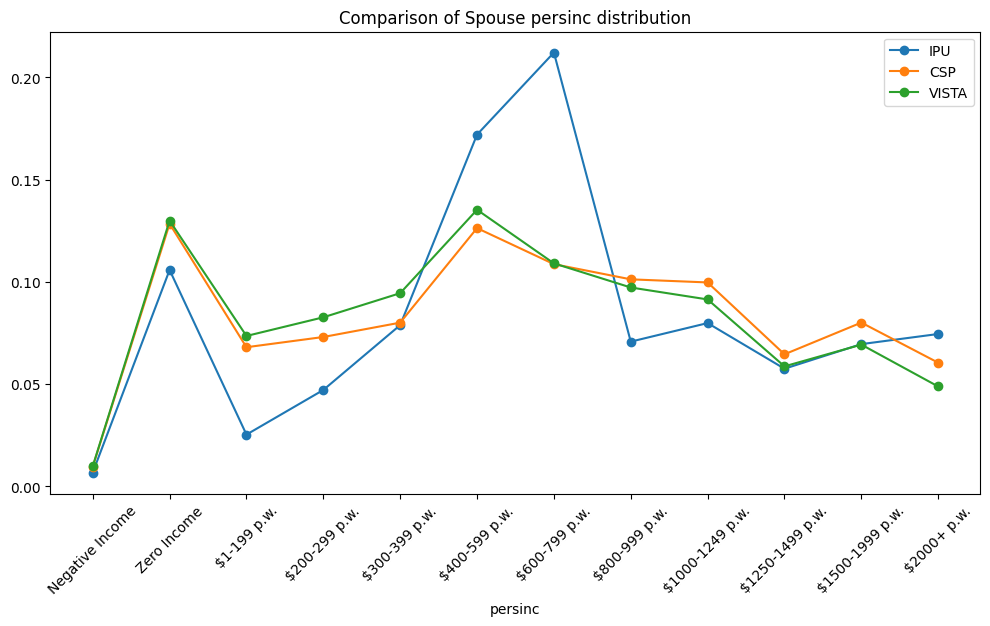

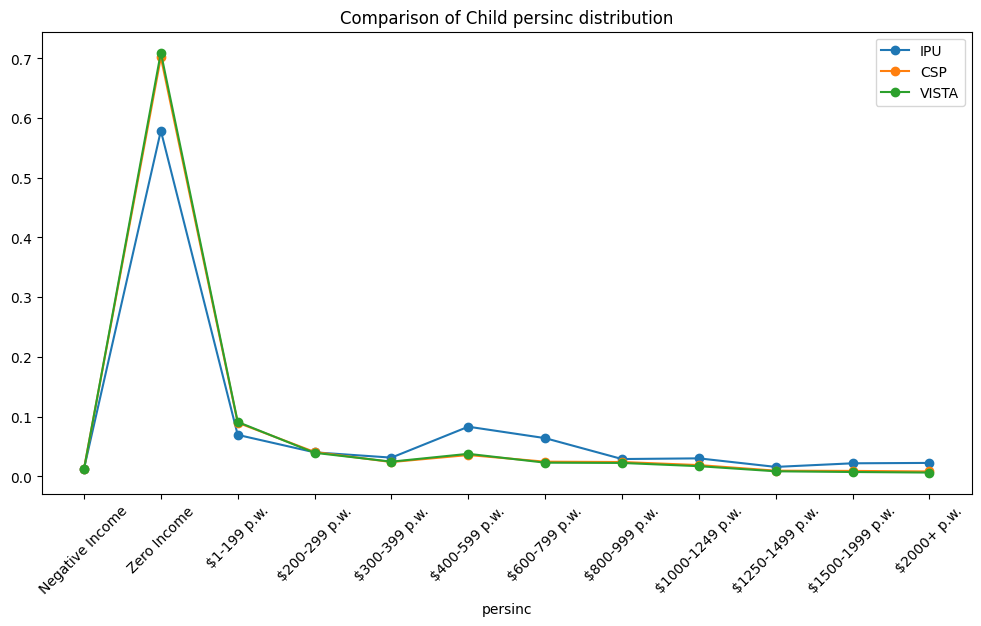

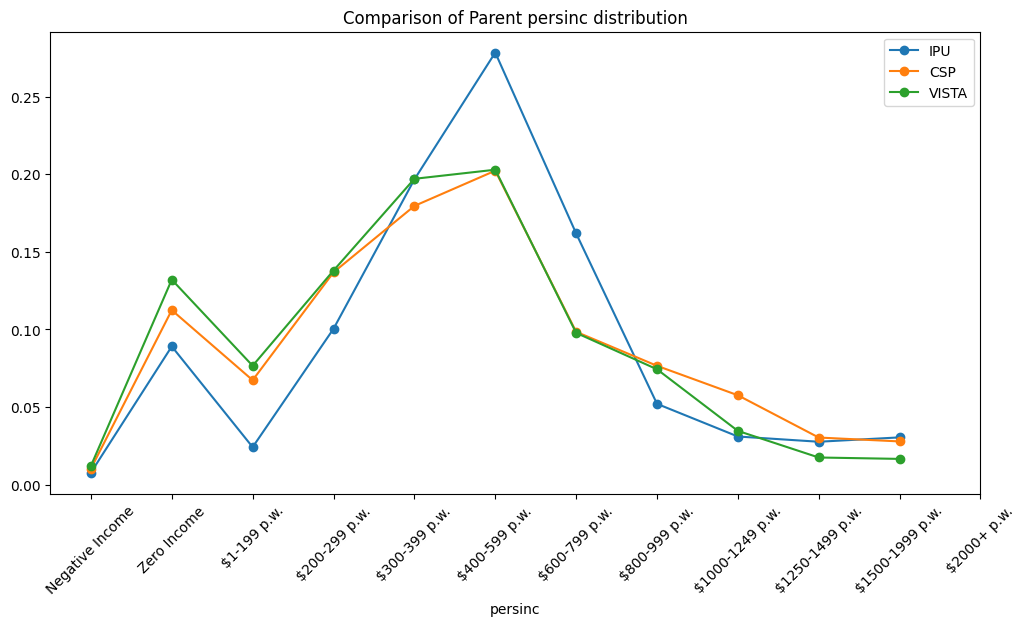

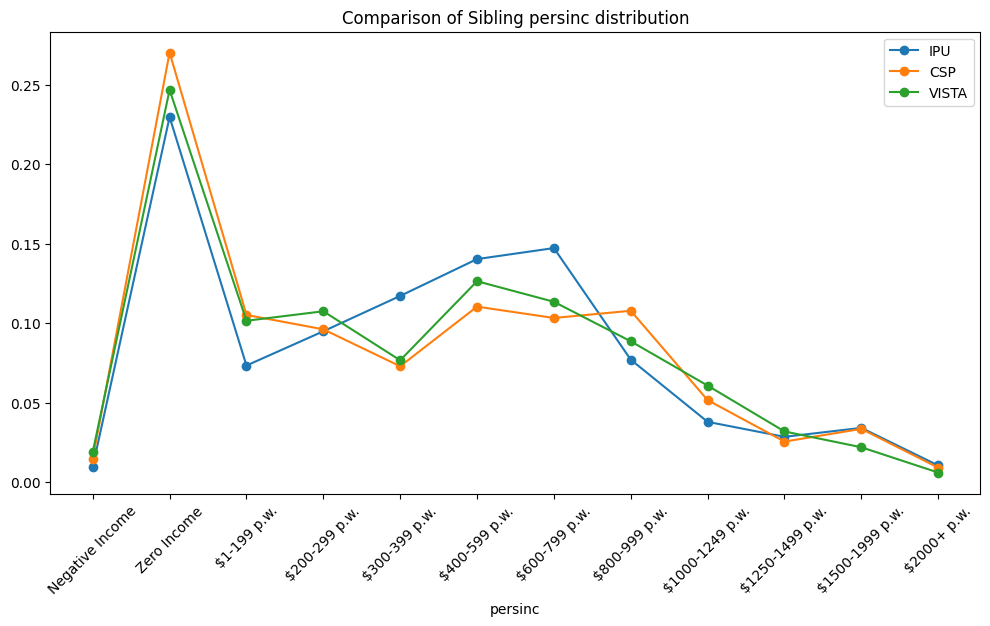

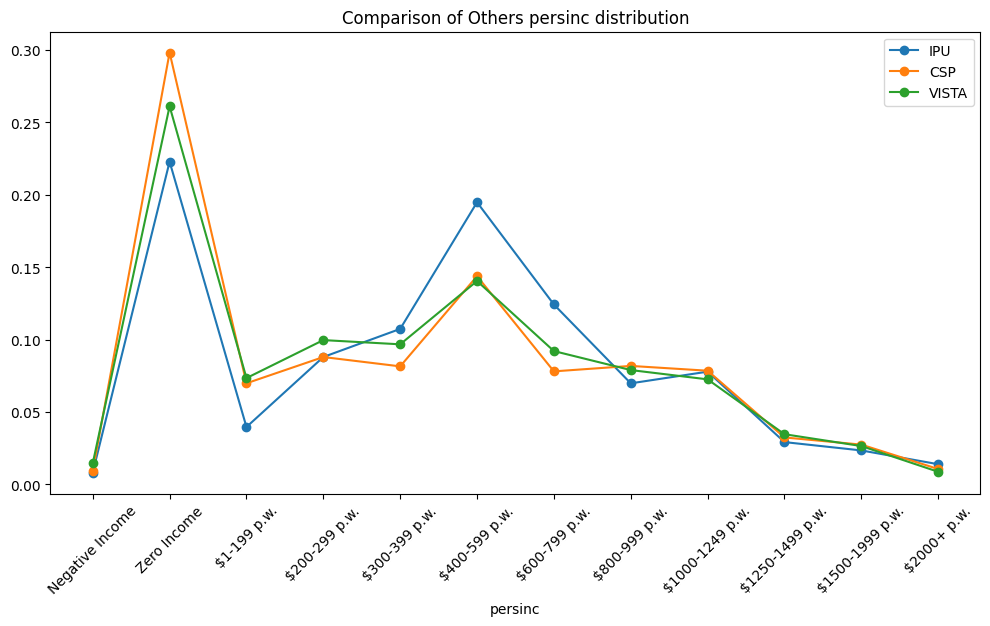

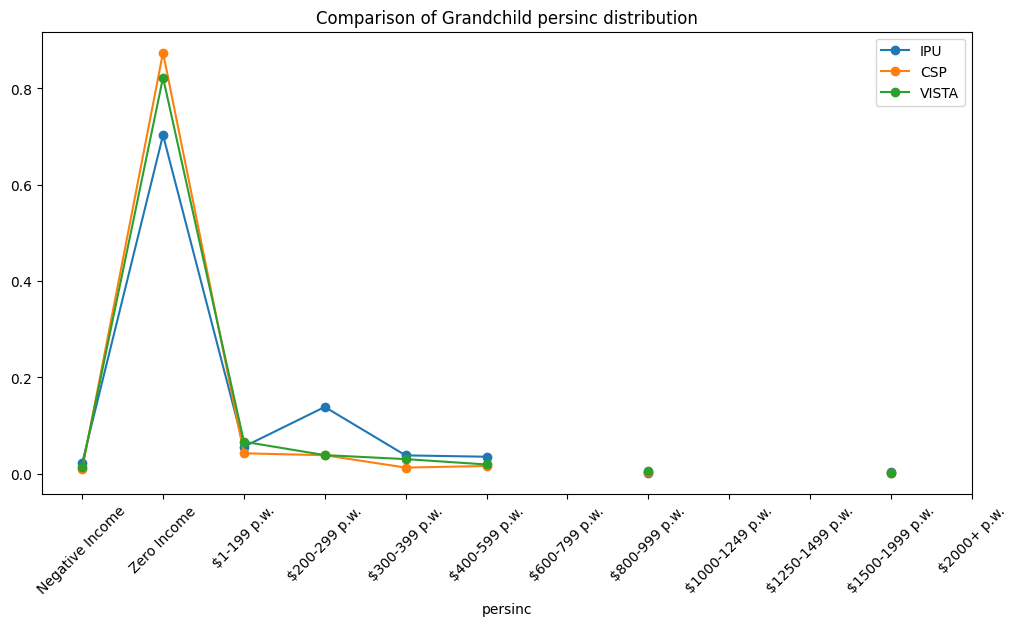

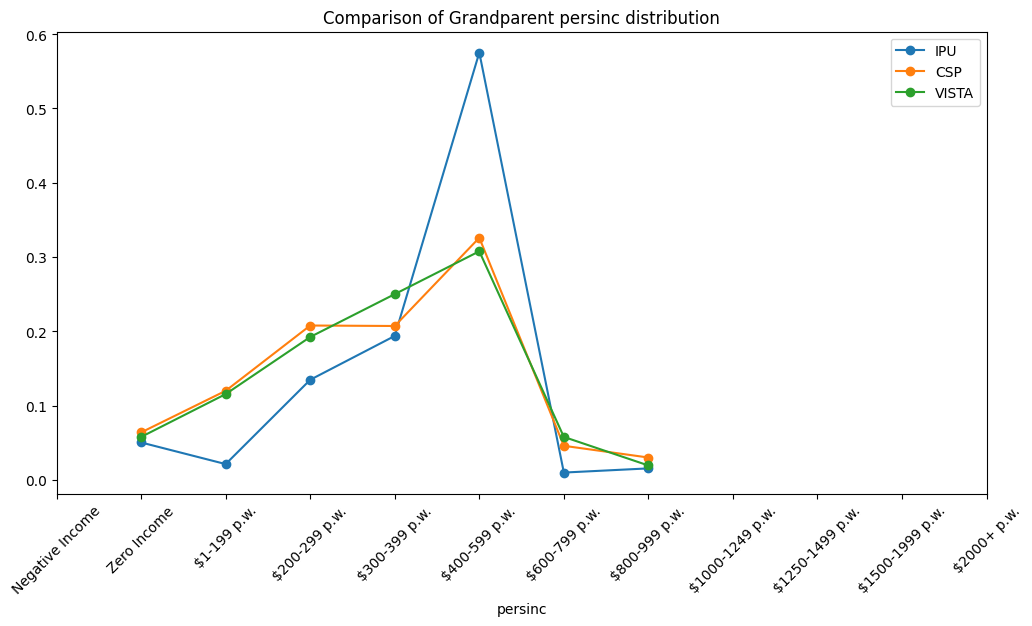

In [10]:
for rela in seed_data["relationship"].unique():
    compare_rela(check, rela, "persinc")
    plt.show()

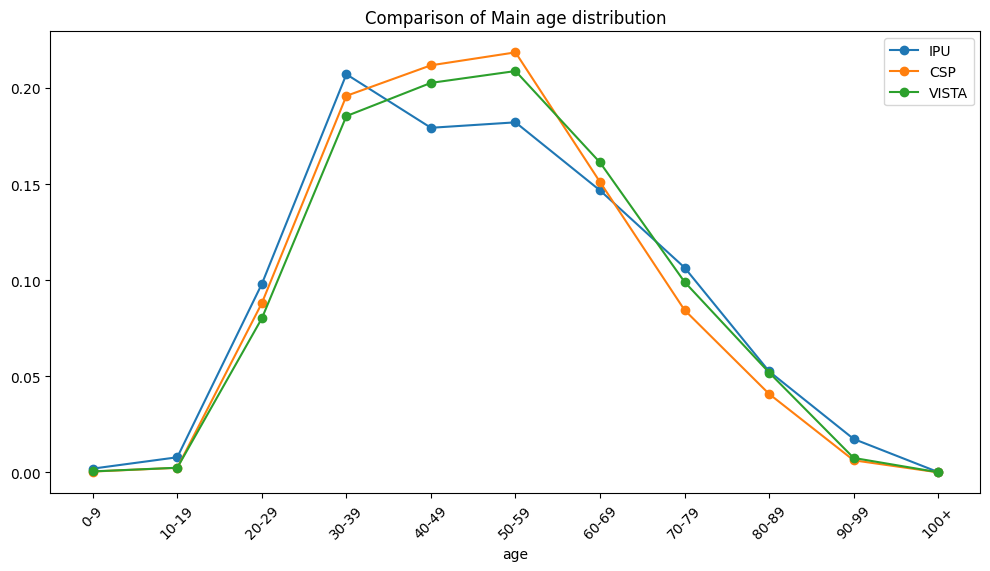

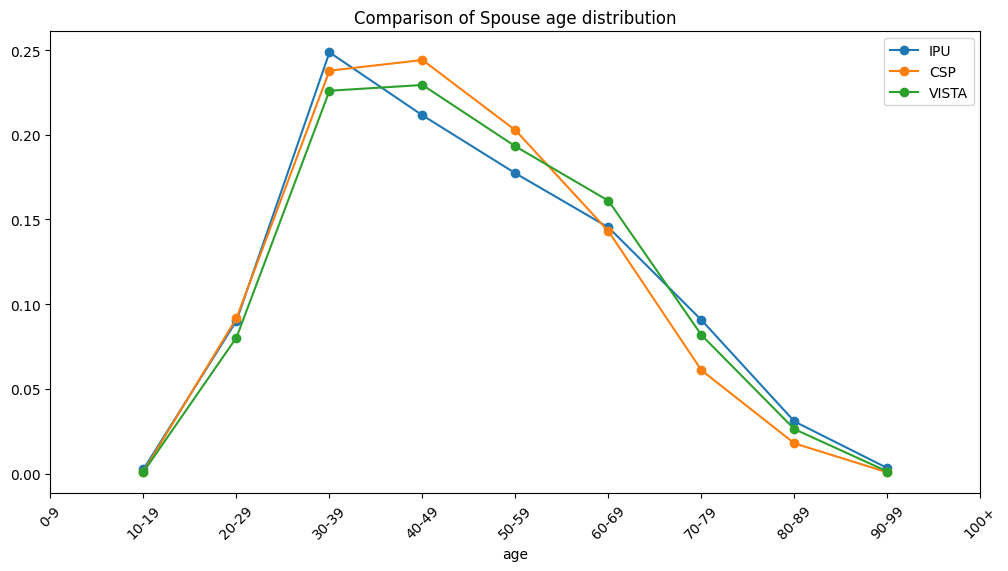

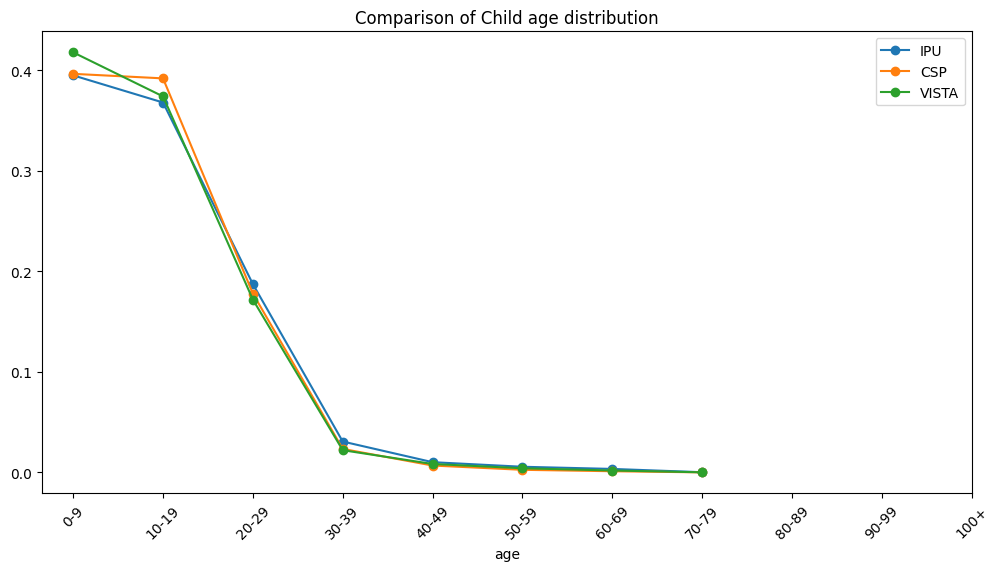

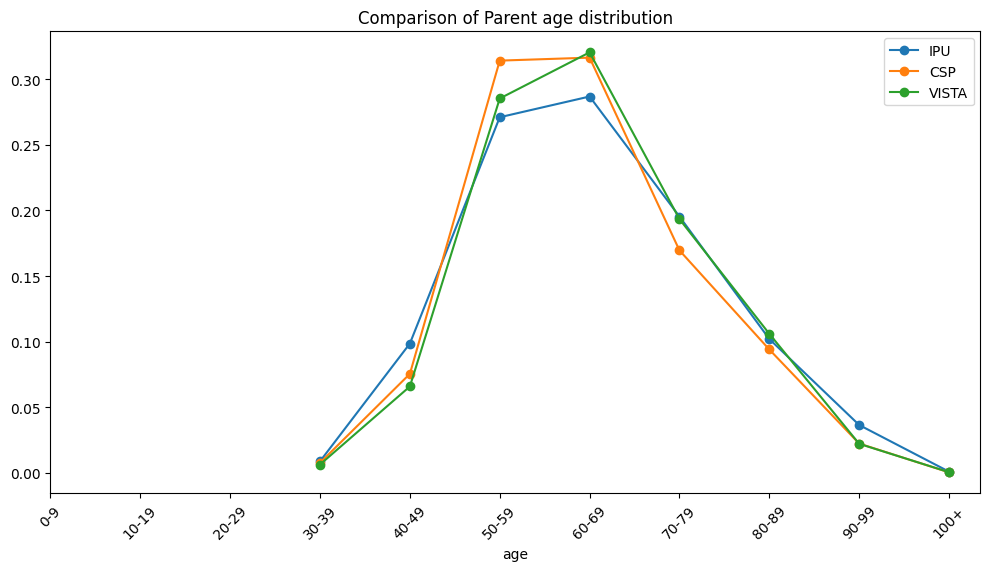

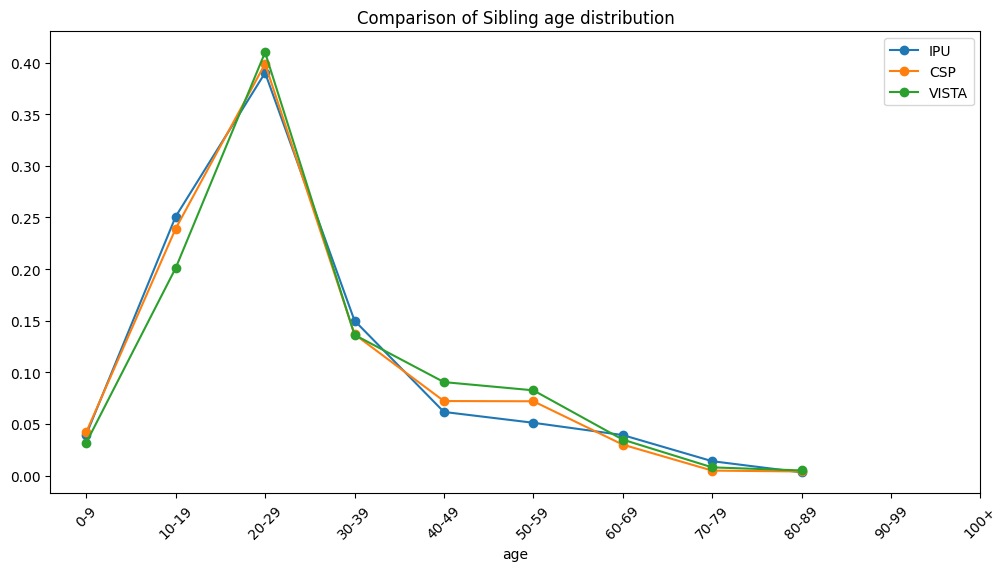

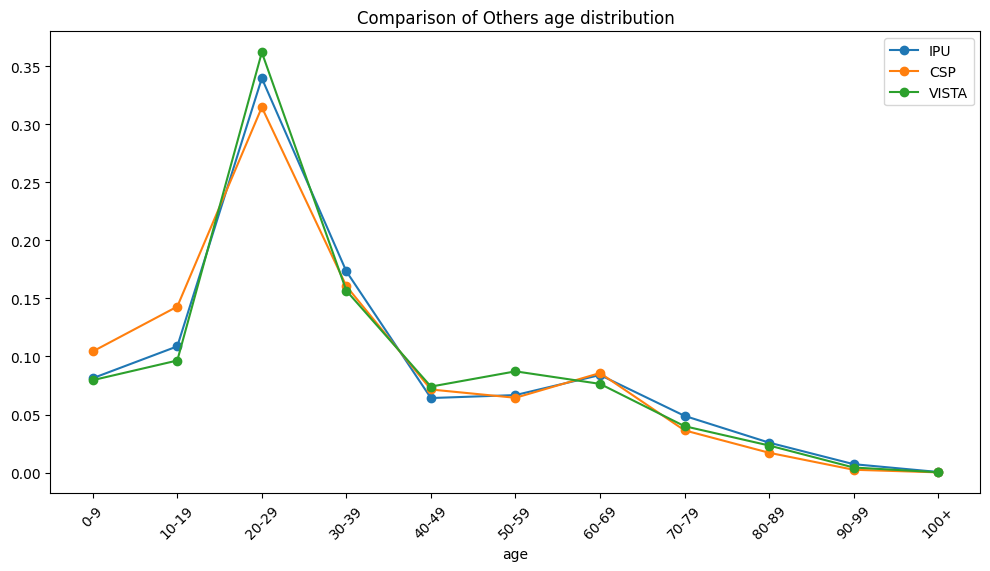

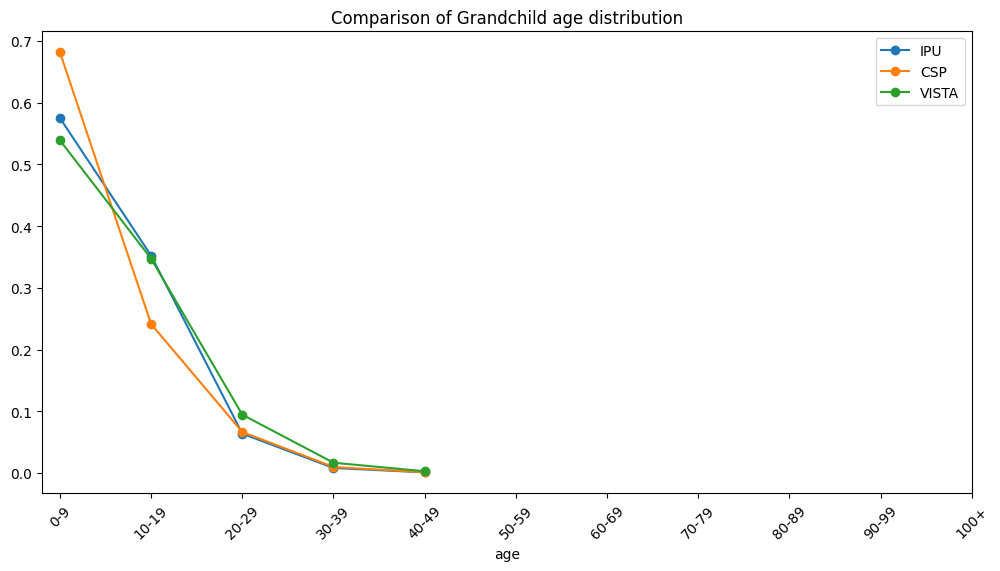

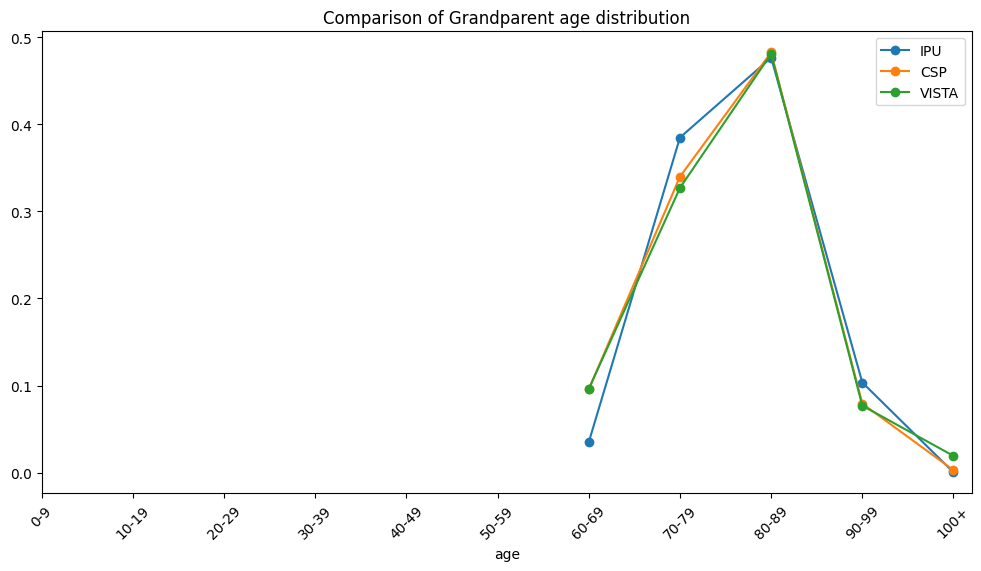

In [11]:
for rela in seed_data["relationship"].unique():
    compare_rela(check, rela, "age")
    plt.show()